In [1]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
#reading freesurfer results
out_dir = Path("/output")
fig_dir = out_dir / "figs"
fsdata_file = out_dir / 'freesurfer_out_preped.csv'
tab_data = pd.read_csv(fsdata_file, sep=',', header=0, index_col=0);
# distribution of large brain parts ratio

tab_data=tab_data.drop(index='sub_0064');
drop_col_list = ['Left_WM_hypointensities', 'Right_WM_hypointensities', '5th_Ventricle'];
tab_data=tab_data.drop(columns=drop_col_list);

201218-05:15:50,713 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0


In [2]:
def lr_ratio(data, items_basic, items_single, items_lr):
    item_left   = [ "Left_"+x  for x in items_lr];
    item_right  = [ "Right_"+x for x in items_lr];
    items_all = items_single + item_left + item_right + items_lr;
    tmp_data = data[items_basic+items_single+item_left+item_right];
    for x in items_lr:
        tmp_data[x]  = tmp_data["Left_"+x] + tmp_data["Right_"+x]
    for x in items_all:
        tmp_data[x+"_r"] = tmp_data[x]/tmp_data["eTIV"]  
    return tmp_data, items_basic+items_all

def resid_ctr(data, var_list):
    from sklearn import linear_model
    import numpy as np
    dat = data.copy()
    nc_data = dat[dat["is_NC"] == 1]
    x_nc = np.array([np.ones(nc_data.shape[0]), np.array((nc_data["is_Male"])), 
                     np.array((nc_data["age"])), np.array((nc_data["eTIV"]))]).T; 
    x_all= np.array([np.ones(dat.shape[0]), np.array((dat["is_Male"])),
                     np.array((dat["age"])), np.array((dat["eTIV"]))]).T;
    reg_list = []; new_col=[];
    for x in var_list:
        reg = linear_model.LinearRegression()
        y_nc= np.array(nc_data[x]);
        reg.fit(x_nc, y_nc);
        tmp_col = x+"_m1"
        dat[tmp_col] = dat[x]-np.matmul(x_all[:,1:], reg.coef_[1:])
        dat[tmp_col+"_resid"] = dat[x]-reg.predict(x_all)
        dat[tmp_col+"_resid_per"] = (dat[x]-reg.predict(x_all))/dat[x]
        reg_list.append(reg); new_col.append(tmp_col);
    return dat, new_col, reg_list 

# plot distribution of brian tissues
def screen_Tukeyhsd(data, test_list):
    import statsmodels.stats.multicomp as mc
    from functools import reduce
    res_all=[]; reject_index=[];
    for i in range(len(test_list)):
        x = test_list[i];
        #print(x)
        tmp_comp = mc.MultiComparison(data[x], data['diagnosis'])
        tmp_res = tmp_comp.tukeyhsd()
        res_all.append(tmp_res.summary())
        if sum(list(tmp_res.reject))>2:
            reject_index.append(i)
            print(str(i)+"th Tukey HSD test positive -->> "+x)
            print(res_all[i])
            #print(res_all[i])
    return res_all, reject_index

In [5]:
# select the data
from sklearn import linear_model
import numpy as np
items_basic = ["diagnosis", "age", "sex", "is_PD", "is_ET","is_NC",
               "is_Male", "is_Female", "eTIV"];
items_single = ["TotalGrayVol", "CerebralWhiteMatterVol", "CortexVol", "CSF", "Brain_Stem", "SubCortGrayVol", 
                "3rd_Ventricle", "4th_Ventricle", "SupraTentorialVol", 
                "CC_Anterior", "CC_Central", "CC_Mid_Anterior", "CC_Mid_Posterior", "CC_Posterior"];
items_lr  = ["Inf_Lat_Vent", "Lateral_Ventricle", 
             "Cerebellum_Cortex", "Cerebellum_White_Matter",
             "Accumbens_area", "Amygdala", "Hippocampus", 
             "Pallidum", "Caudate", "Putamen", "Thalamus_Proper"];
all_data, items_all = lr_ratio(tab_data, items_basic, items_single, items_lr);
rm_AgeSex_list = items_all[8:];
control_var = "eTIV";
all_data_xeTIV, col_list, reg_list = resid_ctr(all_data, rm_AgeSex_list);
# Check regression residuals
resid_list = [x+"_resid_per" for x in col_list ];
#rm_as_data[resid_list].plot.box(vert=False,figsize=(10,20))

/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


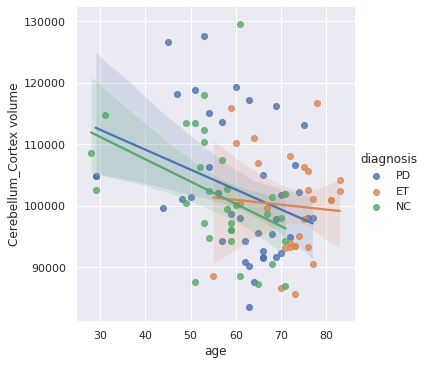

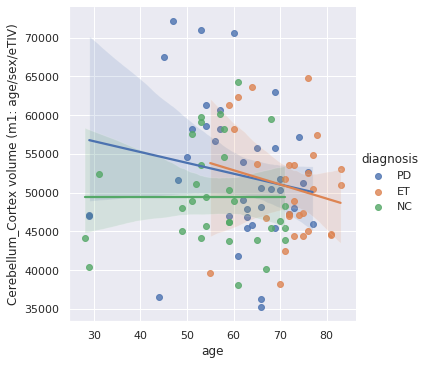

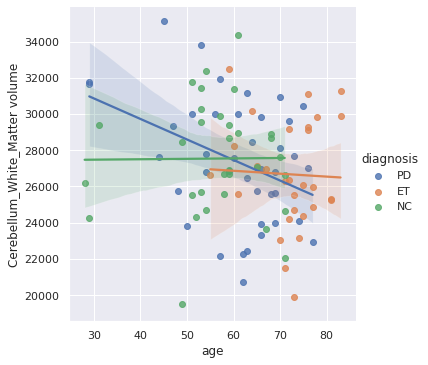

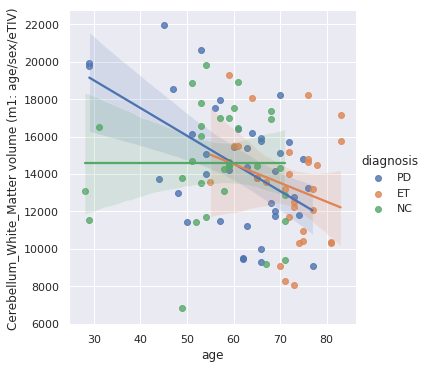

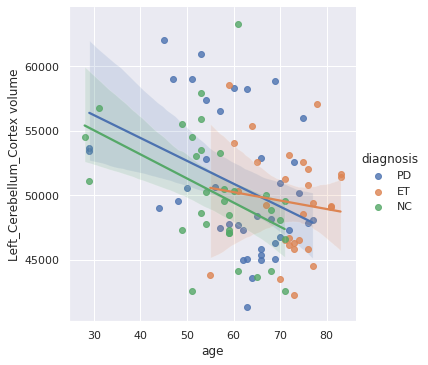

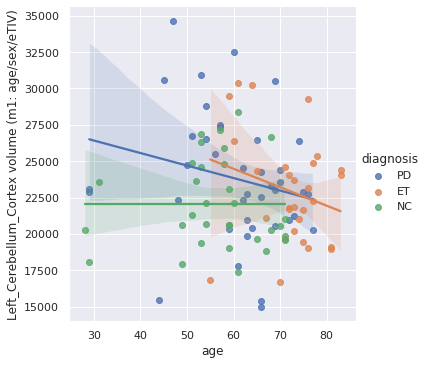

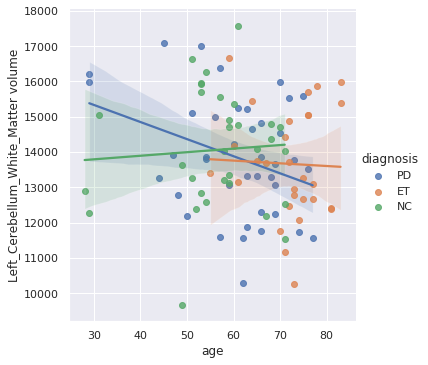

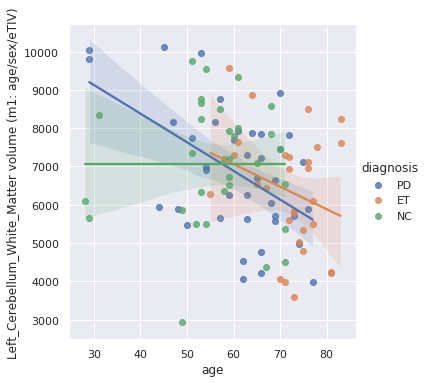

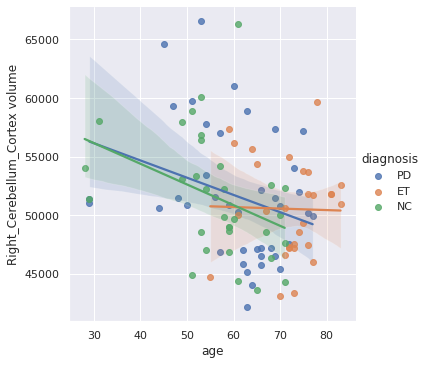

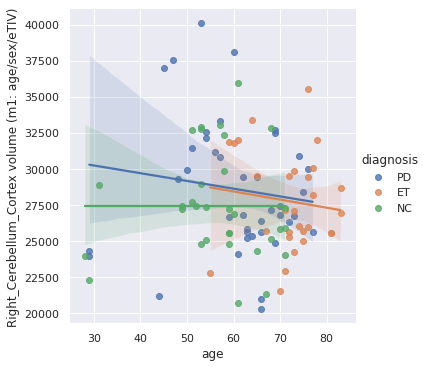

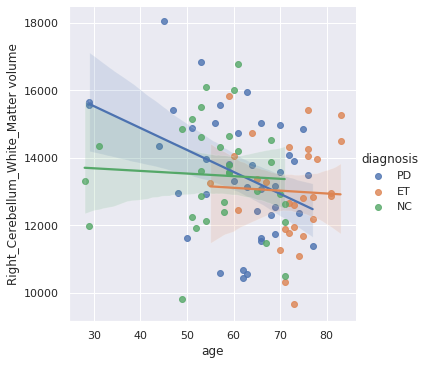

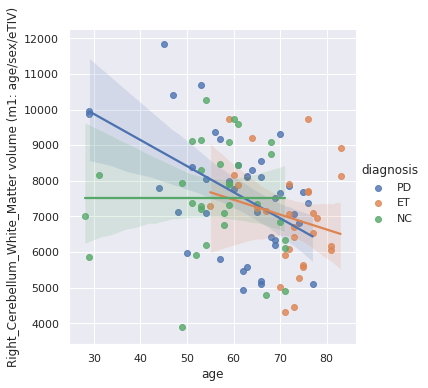

In [10]:
# regression plots of cerebellum
import seaborn as sns
sns.set_theme()
cerebellum_list= ["Cerebellum_Cortex", "Cerebellum_White_Matter",
                  "Left_Cerebellum_Cortex", "Left_Cerebellum_White_Matter",
                  "Right_Cerebellum_Cortex", "Right_Cerebellum_White_Matter"];
def plot_conf(data, items):
    # Plot sepal width as a function of sepal_length across days
    for x in items:
        g_cerebellum_cortex = sns.lmplot(data=data, x="age", y=x, hue="diagnosis")
        g_cerebellum_cortex.set_axis_labels("age", x+" volume")
        g_cerebellum_cortex_asr = sns.lmplot(data=data, x="age", y=x+"_m1", hue="diagnosis")
        g_cerebellum_cortex_asr.set_axis_labels("age", x+ " volume (m1: age/sex/eTIV)")
plot_conf(all_data_xeTIV, cerebellum_list)

In [6]:
all_data_xeTIV.columns

Index(['diagnosis', 'age', 'sex', 'is_PD', 'is_ET', 'is_NC', 'is_Male',
       'is_Female', 'eTIV', 'TotalGrayVol',
       ...
       'Pallidum_x_age_resid_per', 'Caudate_x_age', 'Caudate_x_age_resid',
       'Caudate_x_age_resid_per', 'Putamen_x_age', 'Putamen_x_age_resid',
       'Putamen_x_age_resid_per', 'Thalamus_Proper_x_age',
       'Thalamus_Proper_x_age_resid', 'Thalamus_Proper_x_age_resid_per'],
      dtype='object', length=247)

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
def sts_anova(data, items):
    for x in items:
        print("\n")
        m1_form = x+" ~ C(is_ET)+C(is_PD)"
        m1 = glm(formula=m1_form, data=data)
        res1=m1.fit()
        print(res1.summary2())
        print("******m1*******")
        m2_form = x+"_m1 ~ C(is_ET)+C(is_PD)"
        m2 = glm(formula=m2_form, data=data)
        res2=m2.fit()
        print(res2.summary2())
sts_anova(all_data_xeTIV, cerebellum_list)



                    Results: Generalized linear model
Model:                GLM                AIC:             2147.5395      
Link Function:        identity           BIC:             9557622207.6693
Dependent Variable:   Cerebellum_Cortex  Log-Likelihood:  -1070.8        
Date:                 2020-12-18 05:36   LL-Null:         -1071.3        
No. Observations:     101                Deviance:        9.5576e+09     
Df Model:             2                  Pearson chi2:    9.56e+09       
Df Residuals:         98                 Scale:           9.7527e+07     
Method:               IRLS                                               
-------------------------------------------------------------------------
                 Coef.     Std.Err.    z    P>|z|    [0.025      0.975]  
-------------------------------------------------------------------------
Intercept     101642.2469 1745.7695 58.2220 0.0000 98220.6014 105063.8923
C(is_ET)[T.1]  -1637.0020 2531.9366 -0.6465 0.5179 -6599



                    Results: Generalized linear model
Model:                GLM                AIC:             1830.4029      
Link Function:        identity           BIC:             8225108297.8421
Dependent Variable:   Cerebellum_Cortex  Log-Likelihood:  -912.20        
Date:                 2020-12-18 05:54   LL-Null:         -912.42        
No. Observations:     86                 Deviance:        8.2251e+09     
Df Model:             2                  Pearson chi2:    8.23e+09       
Df Residuals:         83                 Scale:           9.9098e+07     
Method:               IRLS                                               
-------------------------------------------------------------------------
                 Coef.     Std.Err.    z    P>|z|    [0.025      0.975]  
-------------------------------------------------------------------------
Intercept     100473.0667 1915.7988 52.4445 0.0000 96718.1700 104227.9633
C(is_ET)[T.1]   -806.0907 2763.0043 -0.2917 0.7705 -6221

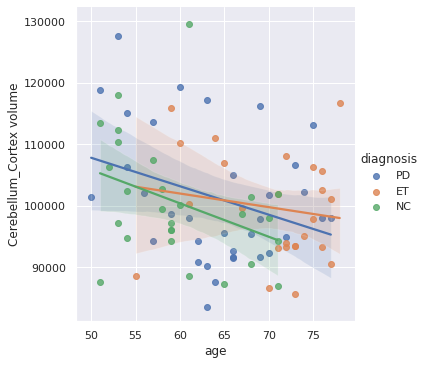

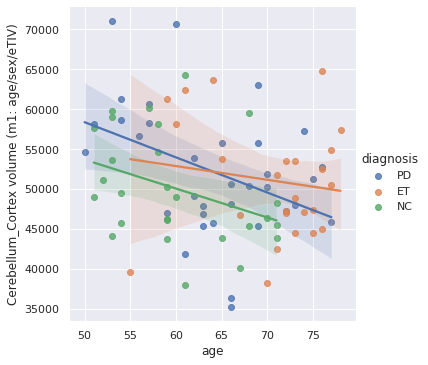

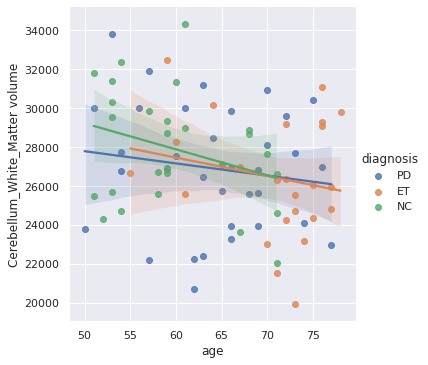

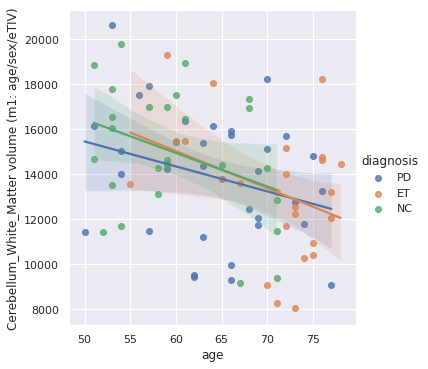

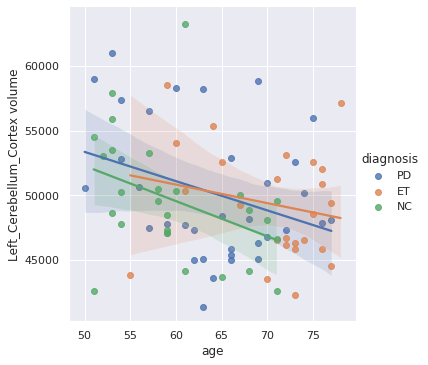

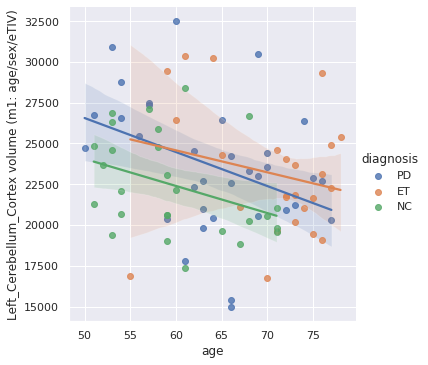

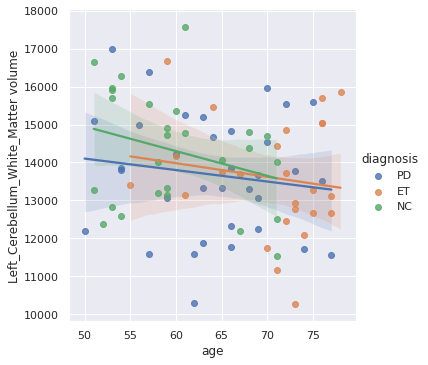

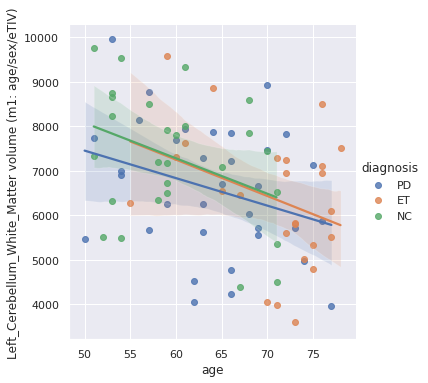

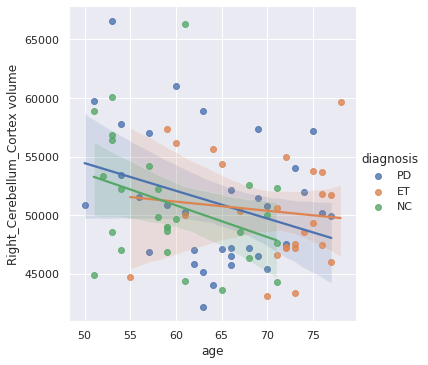

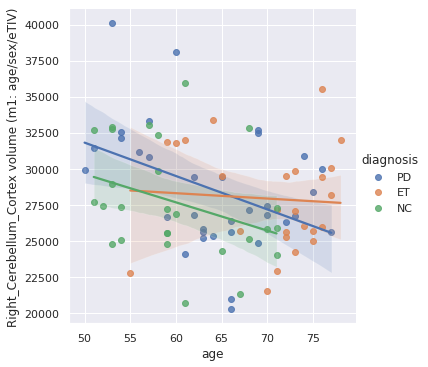

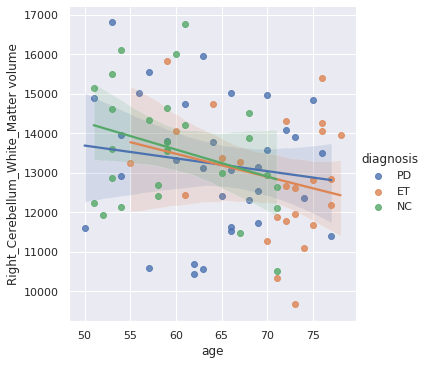

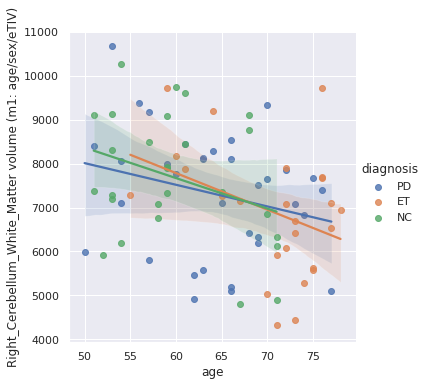

In [11]:
new_data=all_data_xeTIV[all_data_xeTIV["age"]>=50];
stf_data=new_data[new_data["age"]<=80];
plot_conf(stf_data, cerebellum_list)
sts_anova(stf_data, cerebellum_list)


50-80: 
PD :  34
ET :  25
NC :  27
all: 
PD :  40
ET :  29
NC :  32


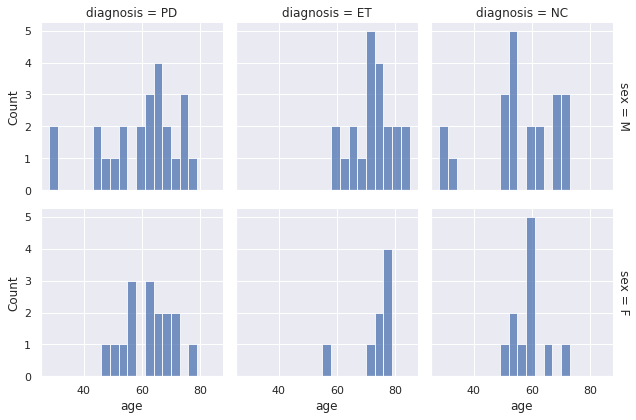

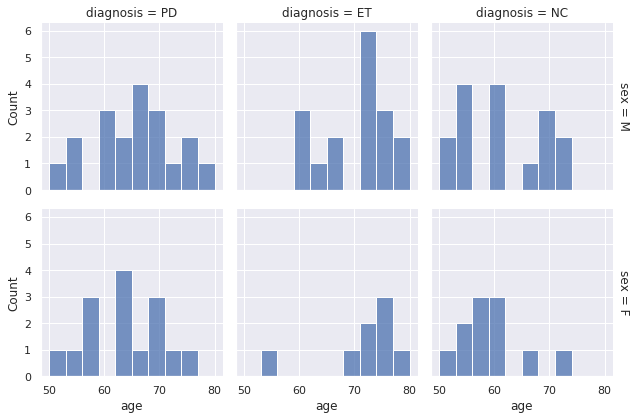

In [14]:
GROUPS  = ['PD','ET','NC']
print("50-80: ")
[print(x, ': ', len(stf_data[stf_data["diagnosis"]==x])) for x in GROUPS]
print("all: ")
[print(x, ': ', len(all_data_xeTIV[all_data_xeTIV["diagnosis"]==x])) for x in GROUPS]

sns.set_theme(style="darkgrid")
sns.displot(
    all_data_xeTIV, x="age", col="diagnosis", row="sex",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True))
sns.displot(
    stf_data, x="age", col="diagnosis", row="sex",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True))

/usr/local/miniconda/lib/python3.7/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


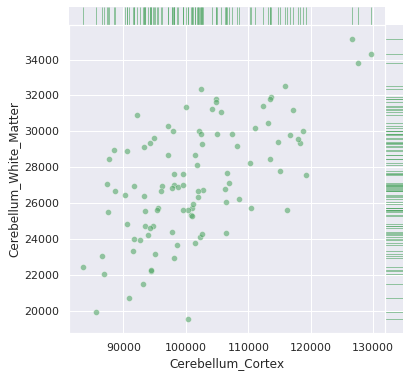

In [19]:
#distribution
g = sns.JointGrid(data=all_data_xeTIV, x="Cerebellum_Cortex", y="Cerebellum_White_Matter", space=0, ratio=17)
g.plot_joint(sns.scatterplot,
             color="g", alpha=.6, legend=False)
g.plot_marginals(sns.rugplot, height=1, color="g",alpha=.6)
                 

/usr/local/miniconda/lib/python3.7/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()




                   Results: Generalized linear model
Model:               GLM                AIC:             1711.8607      
Link Function:       identity           BIC:             6641350129.0221
Dependent Variable:  Cerebellum_Cortex  Log-Likelihood:  -852.93        
Date:                2020-12-18 07:43   LL-Null:         -853.63        
No. Observations:    81                 Deviance:        6.6414e+09     
Df Model:            2                  Pearson chi2:    6.64e+09       
Df Residuals:        78                 Scale:           8.5146e+07     
Method:              IRLS                                               
------------------------------------------------------------------------
                Coef.     Std.Err.    z    P>|z|    [0.025      0.975]  
------------------------------------------------------------------------
Intercept     99353.7769 1809.6485 54.9023 0.0000 95806.9311 102900.6228
C(is_ET)[T.1]  1204.6144 2641.3646  0.4561 0.6483 -3972.3650   6381.5

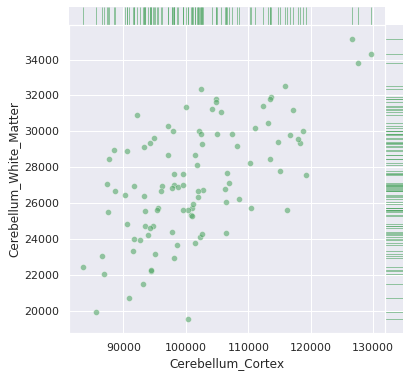

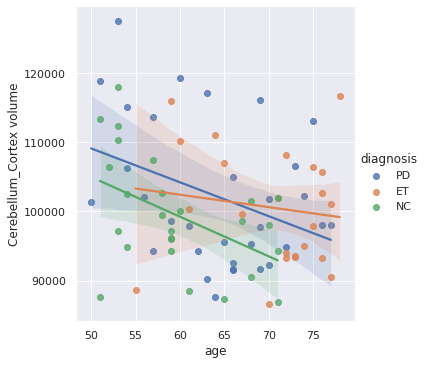

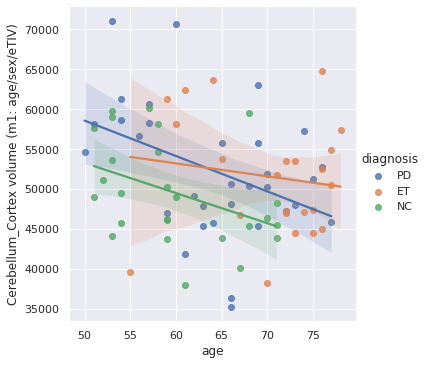

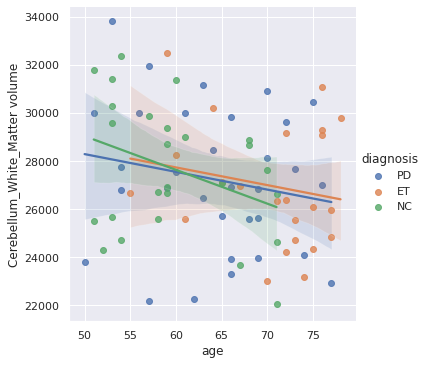

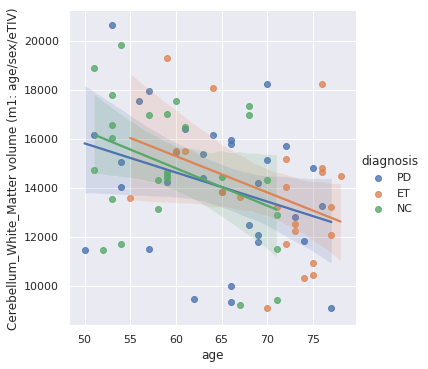

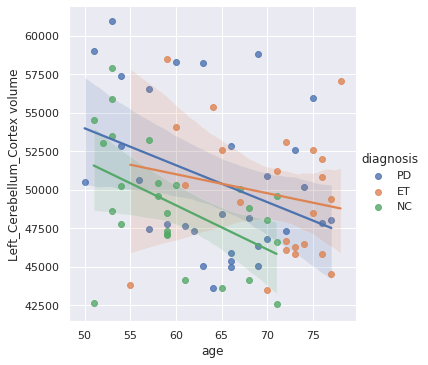

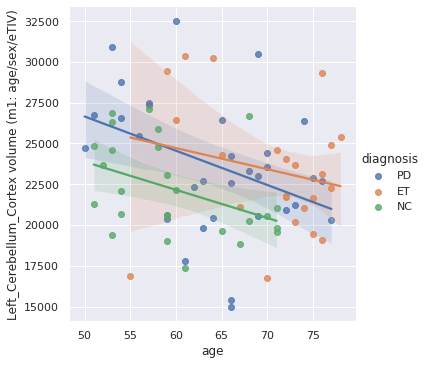

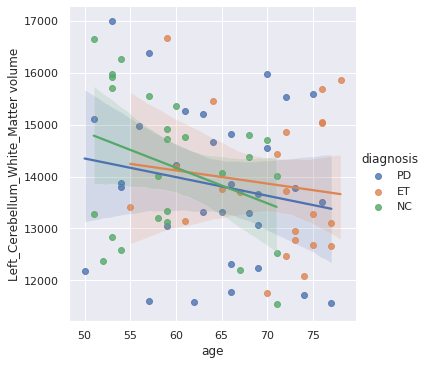

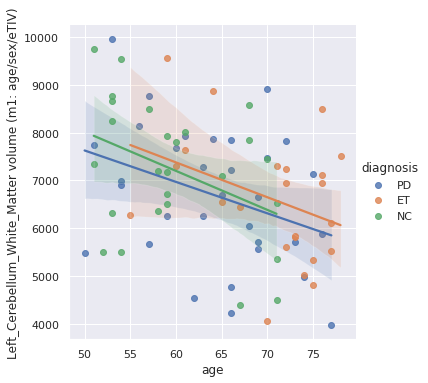

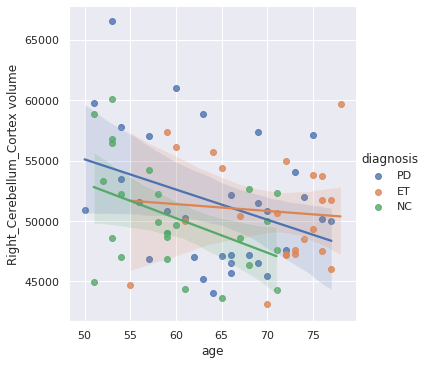

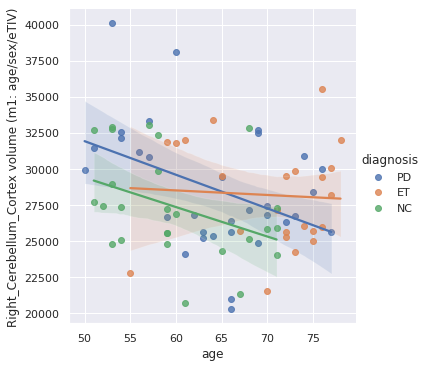

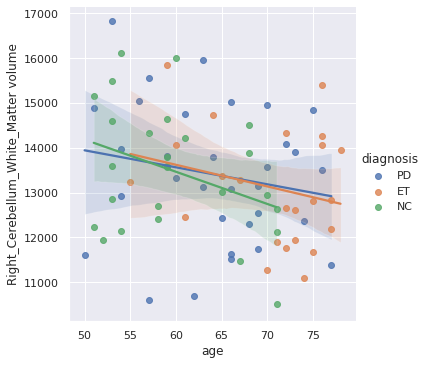

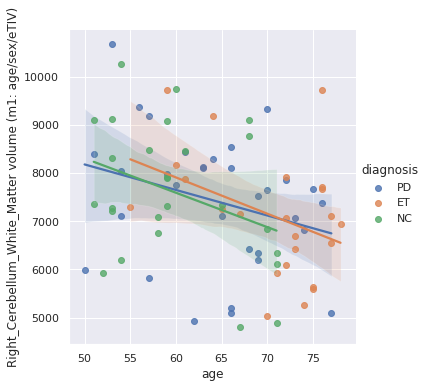

In [27]:
stf_data1=stf_data[stf_data["Cerebellum_White_Matter"]>=22000];
stf_data1=stf_data1[stf_data1["Cerebellum_White_Matter"]<=34000];
stf_data1=stf_data1[stf_data1["Cerebellum_Cortex"]>=85000];
stf_data1=stf_data1[stf_data1["Cerebellum_White_Matter"]<=120000];
g = sns.JointGrid(data=all_data_xeTIV, x="Cerebellum_Cortex", y="Cerebellum_White_Matter", space=0, ratio=17)
g.plot_joint(sns.scatterplot,
             color="g", alpha=.6, legend=False)
g.plot_marginals(sns.rugplot, height=1, color="g",alpha=.6)
plot_conf(stf_data1, cerebellum_list)
sts_anova(stf_data1, cerebellum_list)